## Assemble clean version

After assembling the full dataset, we have a smattering of cell types labeled as Contamination or Doublets that we can remove to get a version that's a good representation of PBMC cell types, if not as accurate of a representation of data that are present straight off of the pipeline.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

## Read old labeled data

In [3]:
old_h5ad_uuid = '23445c96-7b17-41ae-ad53-60bdc3fdb09e'

In [4]:
old_adata = read_adata_uuid(old_h5ad_uuid)

In [5]:
old_adata.shape

(1828803, 1351)

## Read new labeled data

In [6]:
h5ad_uuid = '94541689-2483-4fd4-bcc1-55d8a8eef866'

In [7]:
adata = read_adata_uuid(h5ad_uuid)

In [8]:
adata.shape

(1952128, 1236)

In [44]:
adata.obs['AIFI_L3'] = adata.obs['AIFI_L3'].cat.rename_categories({'Core naive CD8 T cell ':'Core naive CD8 T cell'})

## Compare L3 labels

In [45]:
old_l3 = old_adata.obs[['barcodes', 'AIFI_L3']]
old_l3 = old_l3.rename({'AIFI_L3':'old_l3'}, axis = 1)
old_l3 = old_l3.reset_index(drop = True)
old_l3['old_l3'] = old_l3['old_l3'].astype(str)

In [46]:
new_l3 = adata.obs[['barcodes', 'AIFI_L3']]
new_l3 = new_l3.reset_index(drop = True)
new_l3['AIFI_L3'] = new_l3['AIFI_L3'].astype(str)

In [47]:
comp = old_l3.merge(new_l3, on = 'barcodes', how = 'inner')

In [48]:
comp.shape

(1828265, 3)

In [49]:
comp.head()

,barcodes,old_l3,AIFI_L3
0,cf71f47048b611ea8957bafe6d70929e,CD8 MAIT,CD8 MAIT
1,cf71fb7848b611ea8957bafe6d70929e,CM CD4 T cell,CM CD4 T cell
2,cf7216a848b611ea8957bafe6d70929e,GZMB- CD27+ EM CD4 T cell,GZMB- CD27+ EM CD4 T cell
3,cf72178448b611ea8957bafe6d70929e,Core naive CD4 T cell,SOX4+ naive CD4 T cell
4,cf721a4048b611ea8957bafe6d70929e,Proliferating NK cell,Proliferating NK cell


In [50]:
diff = comp[comp['old_l3'] != comp['AIFI_L3']]

In [51]:
diff.shape

(190671, 3)

In [52]:
diff_old_adata = old_adata[old_adata.obs['barcodes'].isin(diff['barcodes'])]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


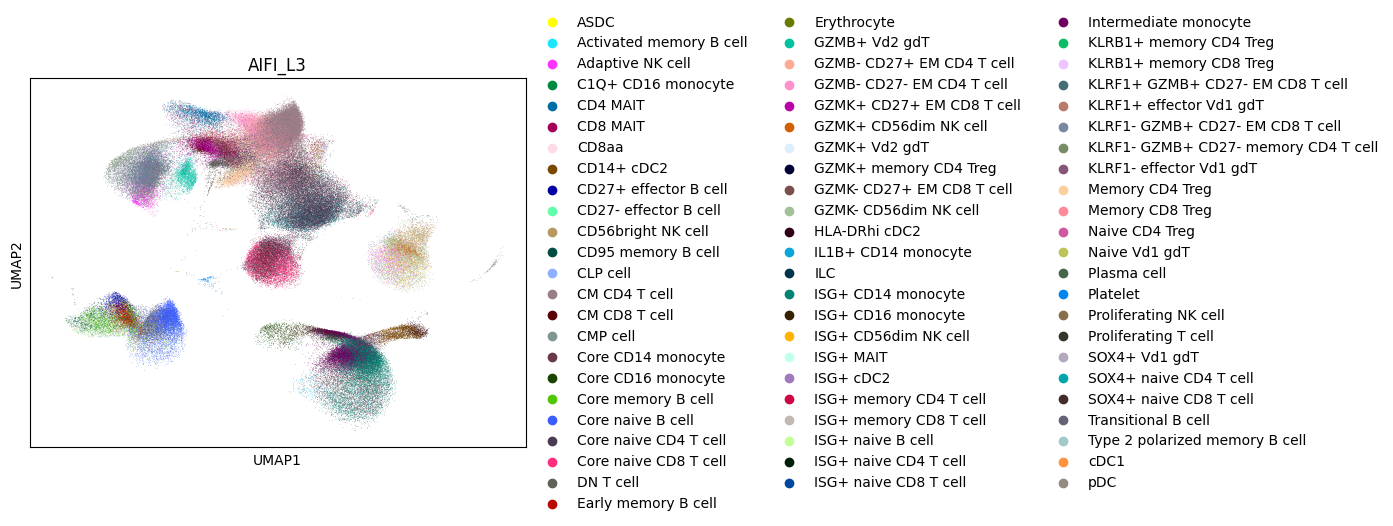

In [53]:
sc.pl.umap(diff_old_adata, color = 'AIFI_L3')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


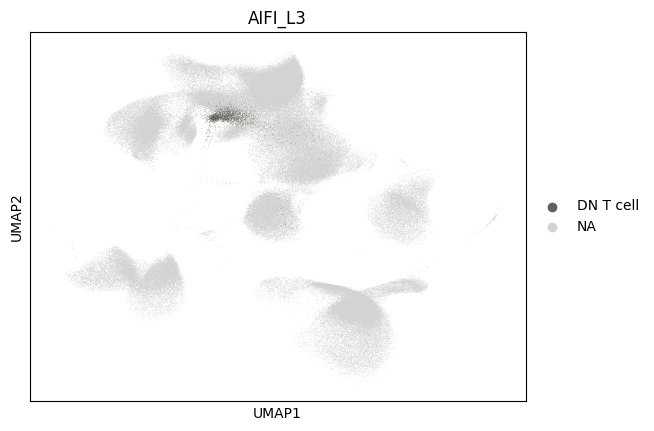

In [69]:
sc.pl.umap(diff_old_adata, color = 'AIFI_L3', groups = ['DN T cell'])

In [54]:
diff_new_adata = adata[adata.obs['barcodes'].isin(diff['barcodes'])]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


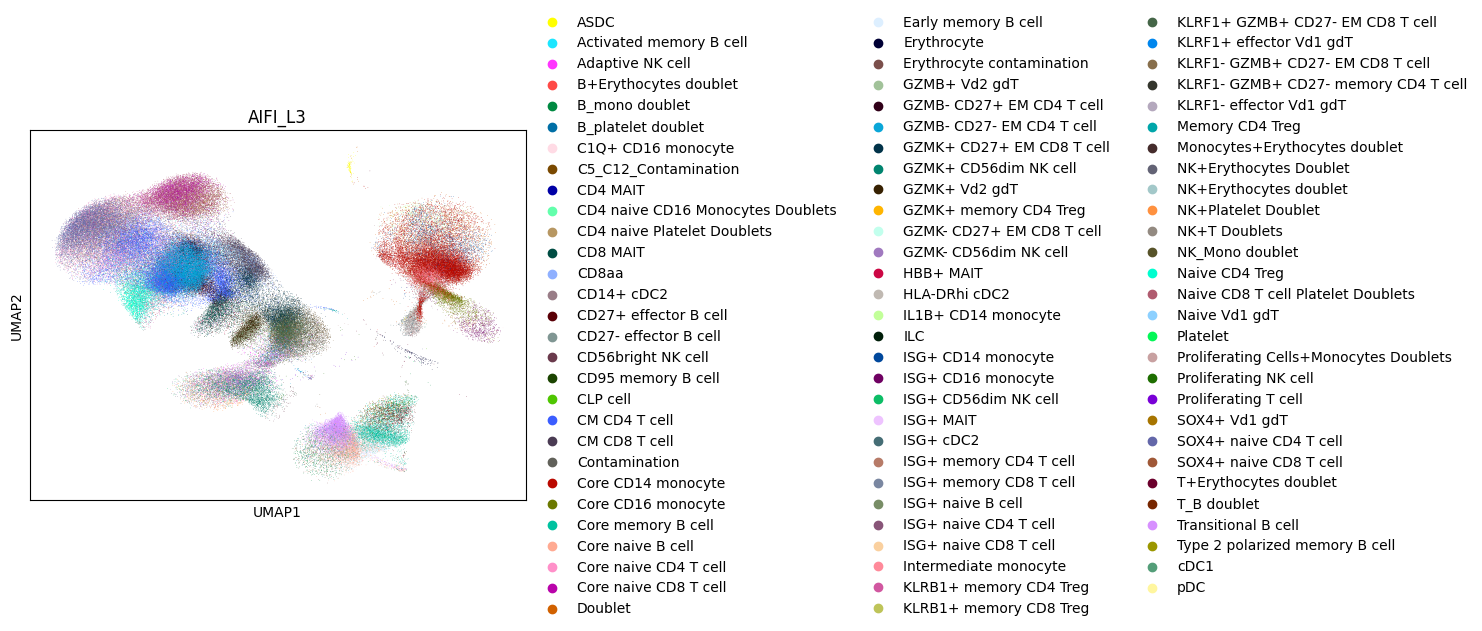

In [55]:
sc.pl.umap(diff_new_adata, color = 'AIFI_L3')

In [58]:
diff['old_l3'].value_counts().head(20)

old_l3
CM CD4 T cell                       35175
Core naive CD4 T cell               23918
ISG+ CD14 monocyte                  12455
GZMB- CD27- EM CD4 T cell            9636
Intermediate monocyte                9057
KLRF1- GZMB+ CD27- EM CD8 T cell     8723
Core naive B cell                    7405
Core naive CD8 T cell                6945
GZMB- CD27+ EM CD4 T cell            5536
Core CD14 monocyte                   4939
GZMK- CD56dim NK cell                4522
GZMK+ CD27+ EM CD8 T cell            3963
Memory CD4 Treg                      3311
SOX4+ naive CD8 T cell               3220
CM CD8 T cell                        3121
Core memory B cell                   2942
KLRF1+ GZMB+ CD27- EM CD8 T cell     2887
GZMB+ Vd2 gdT                        2773
Transitional B cell                  2417
GZMK- CD27+ EM CD8 T cell            2377
Name: count, dtype: int64

In [68]:
diff_frac = diff['old_l3'].value_counts() / old_l3['old_l3'].value_counts()
diff_frac.sort_values(ascending = False).head(20)

old_l3
DN T cell                         1.000000
Memory CD8 Treg                   0.997717
GZMK+ memory CD4 Treg             0.833488
CD4 MAIT                          0.672085
Early memory B cell               0.628980
Intermediate monocyte             0.496737
SOX4+ naive CD8 T cell            0.484065
ISG+ MAIT                         0.387068
GZMK- CD27+ EM CD8 T cell         0.354617
CD14+ cDC2                        0.313081
CD95 memory B cell                0.262089
Transitional B cell               0.252112
ISG+ CD14 monocyte                0.235814
Type 2 polarized memory B cell    0.233358
SOX4+ Vd1 gdT                     0.214665
Memory CD4 Treg                   0.211417
CM CD4 T cell                     0.202647
ISG+ CD56dim NK cell              0.195097
KLRF1+ effector Vd1 gdT           0.179784
CD27+ effector B cell             0.168687
Name: count, dtype: float64

In [17]:
diff['AIFI_L3'][diff['old_l3'] == 'Core naive CD8 T cell'].value_counts()

AIFI_L3
Core naive CD8 T cell                 110260
Naive CD8 T cell Platelet Doublets      4006
SOX4+ naive CD8 T cell                  1734
CM CD8 T cell                            565
Core naive CD4 T cell                    386
CM CD4 T cell                            103
ISG+ naive CD8 T cell                     86
Contamination                             18
Naive Vd1 gdT                             13
SOX4+ naive CD4 T cell                    11
ISG+ naive CD4 T cell                     10
Memory CD4 Treg                            3
CD4 naive Platelet Doublets                3
Naive CD4 Treg                             2
GZMB- CD27+ EM CD4 T cell                  1
ISG+ memory CD4 T cell                     1
GZMK+ memory CD4 Treg                      1
GZMK- CD27+ EM CD8 T cell                  1
GZMK+ CD27+ EM CD8 T cell                  1
Name: count, dtype: int64

In [18]:
diff['old_l3'].value_counts()

old_l3
Core naive CD8 T cell        117205
CM CD4 T cell                 35175
Core naive CD4 T cell         23918
ISG+ CD14 monocyte            12455
GZMB- CD27- EM CD4 T cell      9636
                              ...  
Plasma cell                      20
cDC1                             14
CMP cell                          9
ASDC                              6
CLP cell                          1
Name: count, Length: 70, dtype: int64

CM CD4 T cells

In [19]:
diff['AIFI_L3'][diff['old_l3'] == 'CM CD4 T cell'].value_counts()

AIFI_L3
GZMB- CD27- EM CD4 T cell               27658
Core naive CD4 T cell                    3784
GZMB- CD27+ EM CD4 T cell                2283
ISG+ memory CD4 T cell                    522
Naive CD4 Treg                            244
CM CD8 T cell                             242
KLRB1+ memory CD4 Treg                    104
Memory CD4 Treg                            97
ISG+ naive CD4 T cell                      66
Contamination                              53
ISG+ memory CD8 T cell                     32
Core naive CD8 T cell                      17
Naive CD8 T cell Platelet Doublets         16
Naive Vd1 gdT                              12
GZMK+ CD27+ EM CD8 T cell                   7
GZMK+ memory CD4 Treg                       6
CD4 naive Platelet Doublets                 6
SOX4+ naive CD4 T cell                      5
T+Erythocytes doublet                       5
Doublet                                     3
Proliferating T cell                        2
SOX4+ Vd1 gdT             

Looks like a shift from the general CD4 CM population towards the GZMB- CD27- EM population.

Does this make sense based on expression?

New version:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


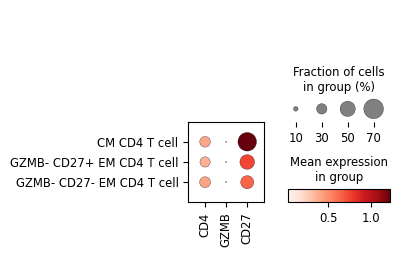

In [24]:
markers = ['CD4', 'GZMB', 'CD27']

diff_set = adata[adata.obs['barcodes'].isin()]
check_set = adata[adata.obs['AIFI_L3'].isin(['CM CD4 T cell', 'GZMB- CD27- EM CD4 T cell', 'GZMB- CD27+ EM CD4 T cell'])]

sc.pl.dotplot(
    check_set,
    var_names = markers,
    groupby = 'AIFI_L3',
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


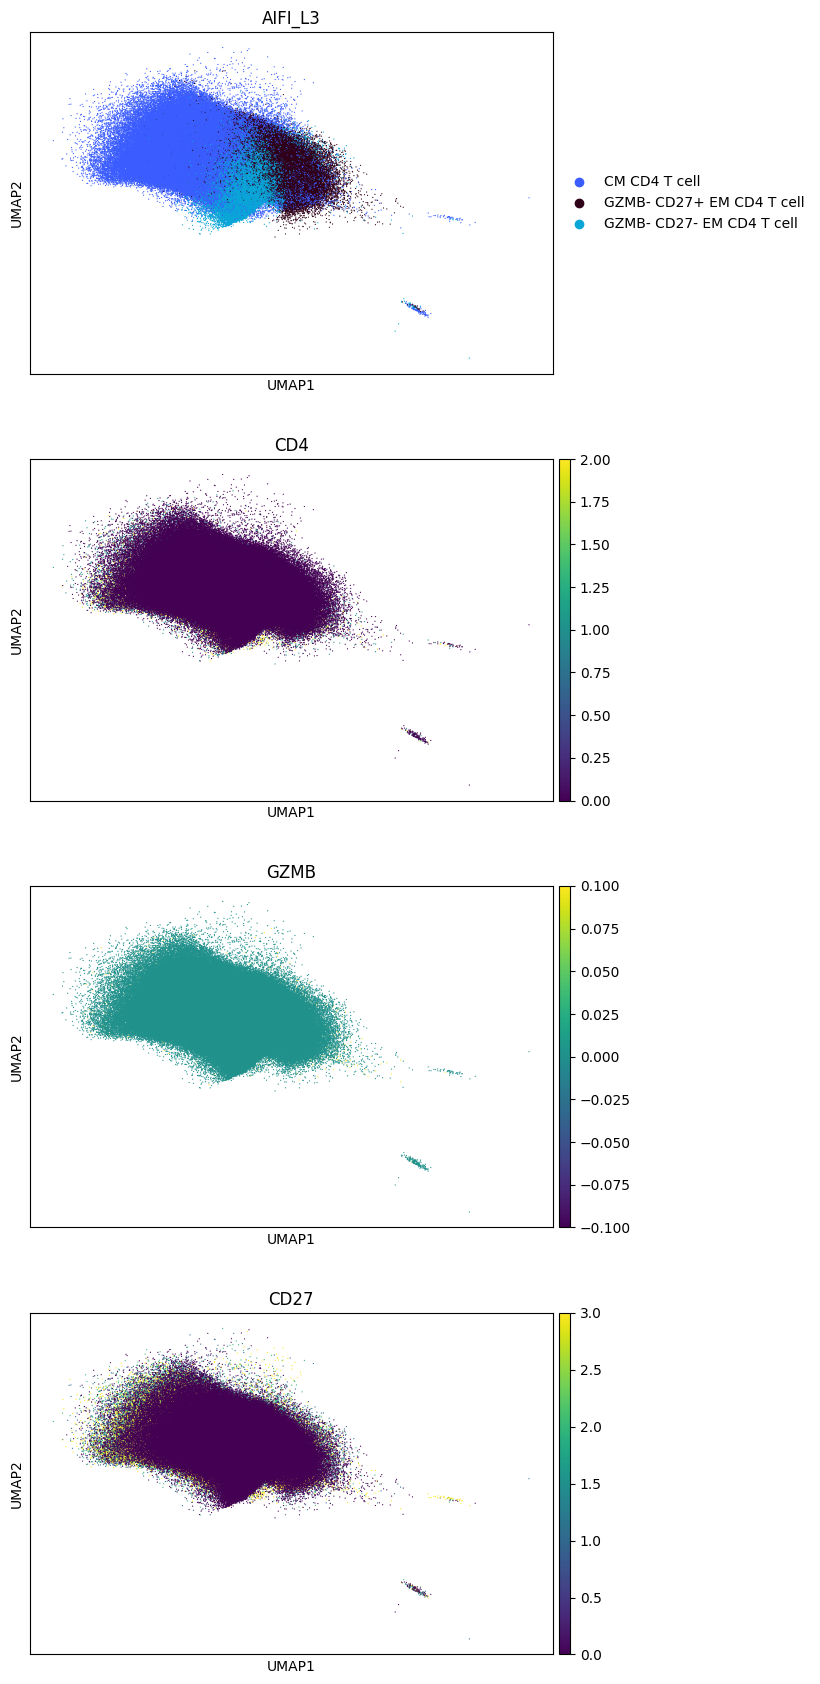

In [32]:
sc.pl.umap(check_set,
           color = ['AIFI_L3'] + markers,
           vmax = 'p95',
           size = 3,
           ncols = 1)

Old version:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


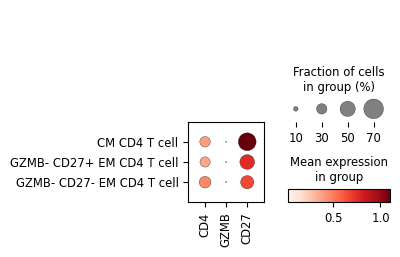

In [36]:
markers = ['CD4', 'GZMB', 'CD27']

old_set = old_adata[old_adata.obs['AIFI_L3'].isin(['CM CD4 T cell', 'GZMB- CD27- EM CD4 T cell', 'GZMB- CD27+ EM CD4 T cell'])]

sc.pl.dotplot(
    old_set,
    var_names = markers,
    groupby = 'AIFI_L3',
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


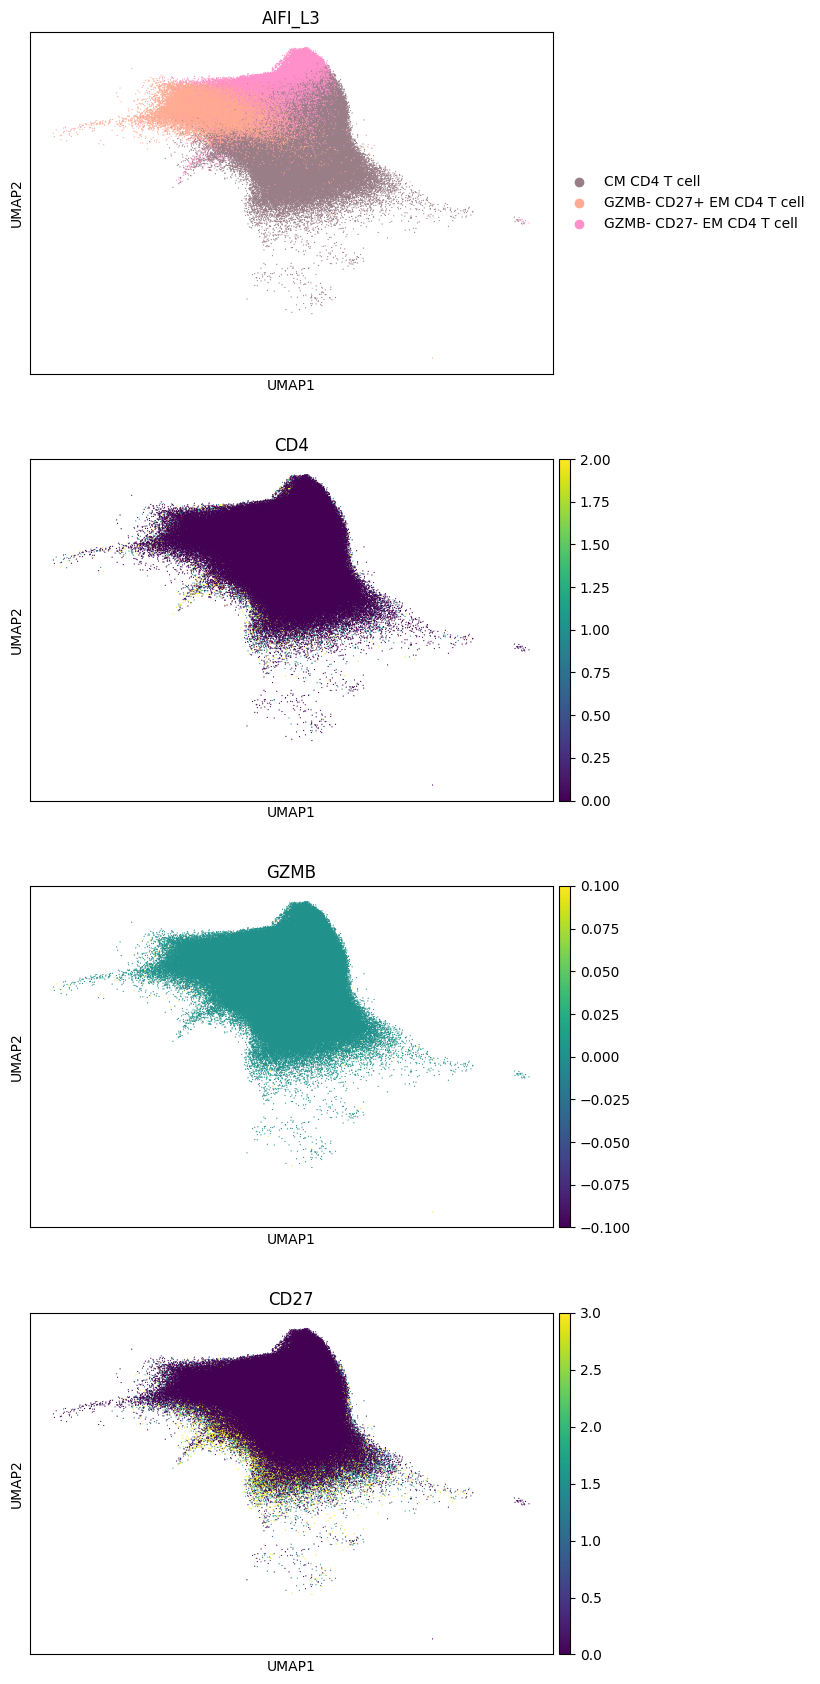

In [37]:
sc.pl.umap(old_set,
           color = ['AIFI_L3'] + markers,
           vmax = 'p95',
           size = 3,
           ncols = 1)

Core Naive CD4 T cells

In [ ]:
diff['AIFI_L3'][diff['old_l3'] == 'Core naive CD4 T cell'].value_counts()

In [33]:
diff['AIFI_L3'].value_counts()

AIFI_L3
Core naive CD8 T cell        114126
GZMB- CD27- EM CD4 T cell     30052
CM CD4 T cell                 20749
Core CD14 monocyte            18575
SOX4+ naive CD4 T cell         8983
                              ...  
Platelet                          4
B+Erythocytes doublet             2
pDC                               1
NK+Erythocytes doublet            1
CLP cell                          1
Name: count, Length: 86, dtype: int64

This is pretty weird - lots of assignment to other types, including monocytes?

In [36]:
import session_info
session_info.show()